In [62]:
import numpy as np
import pandas as pd

from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
# from sklearn.impute import SimpleImputer     # verified that there're no null values accordingly we don't need SimpleImputer

from sklearn.metrics import roc_auc_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

import optuna
from optuna.samplers import TPESampler
from tqdm import tqdm


plt.rcParams['axes.unicode_minus'] = False
sns.set(font_scale = 1)  
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

print("Let's start!")

Let's start!


In [2]:
trn = pd.read_csv('./input/tabular-playground-series-nov-2021/train.csv', index_col = 'id')
tst = pd.read_csv('./input/tabular-playground-series-nov-2021/test.csv', index_col = 'id')

display(trn.shape, trn.head(3), tst.shape, tst.head(3))

(600000, 101)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.106643,3.59437,132.8040,3.18428,0.081971,1.18859,3.73238,2.266270,2.09959,0.012330,1.607190,-0.318058,0.560137,2.80688,1.35114,2.535930,0.197527,0.676494,1.98979,-3.842450,0.037380,0.230322,3.33055,0.009397,0.144738,3.05131,1.30362,0.033225,-0.018284,2.74821,-0.009294,-0.036271,-0.049871,0.019484,3.898460,11.2863,1.13802,3.366880,4.94446,-0.105772,2.11345,3.452230,0.789430,1.113210,1.49157,2.440370,0.041824,3.35537,0.053691,1.701270,0.908831,0.094902,0.030219,0.597024,4.44341,1.586490,-0.068686,-0.108268,0.061044,0.046099,0.017113,-0.027551,0.019483,-0.048826,0.050748,3.729300,5.017440,4.186880,0.063342,0.121043,1.37175,4.017450,0.167613,0.039754,2.04236,-0.016614,0.107679,3.507250,0.013660,-0.097023,5.39607,0.244457,3.49184,0.113090,-0.015472,4.208790,4.10656,0.037227,-0.118814,0.067086,0.010739,1.09862,0.013331,-0.011715,0.052759,0.065400,4.211250,1.97877,0.085974,0.240496,0
1,0.125021,1.67336,76.5336,3.37825,0.099400,5.09366,1.27562,-0.471318,4.54594,0.037706,0.331749,0.325091,0.062040,2.26215,4.33943,-0.224999,0.233586,3.381280,1.90299,0.067874,-0.051268,0.006135,2.60444,0.103441,0.067638,4.75362,1.85552,-0.181834,0.008359,3.16634,0.011850,0.022292,0.069320,0.117109,0.315276,24.4807,1.67227,-0.409067,4.95475,0.092358,2.60318,1.954690,0.005896,3.289340,2.56453,0.817706,0.025997,4.61749,1.575540,0.066105,0.681634,0.025247,0.183500,0.110038,2.74612,0.835586,0.188196,4.960640,0.136087,-0.008493,-0.015264,-0.010841,0.064584,0.102548,0.093611,0.964089,0.630422,4.307340,0.091289,-0.036360,3.61767,3.103240,0.000657,0.051302,1.92462,0.123294,-0.022671,1.548120,-0.010397,0.058330,3.66131,-0.118386,2.35739,-0.009112,0.178701,4.097350,3.53289,0.005244,0.121381,0.109968,0.135838,3.46017,0.017054,0.124863,0.154064,0.606848,-0.267928,2.57786,-0.020877,0.024719,0
2,0.036330,1.49747,233.5460,2.19435,0.026914,3.12694,5.05687,3.849460,1.80187,0.056995,0.328684,2.968810,0.105244,2.06949,5.30986,1.354790,-0.262018,1.379080,1.48091,0.020542,-0.008806,0.109348,1.68365,0.038180,0.123716,1.11248,3.57166,0.120601,0.082069,2.23352,0.002270,0.045182,0.014405,0.011599,-0.502849,33.7382,1.41750,1.071350,3.22296,2.122030,3.08216,0.637555,-0.006822,-0.390943,17.34570,3.700430,-0.033600,1.57824,0.051978,-0.002004,2.690960,0.018367,-0.030468,0.111409,2.18747,-0.325000,-0.019944,3.455030,0.068105,-0.009812,-0.010627,0.027571,-0.007121,-0.048914,-0.002574,1.865090,2.404170,0.411741,0.057749,0.525174,2.16879,0.828297,0.089848,0.093744,4.94901,-0.010978,0.076671,0.266784,0.038691,0.382731,3.84760,-0.121482,3.74084,0.147098,-0.016566,0.614651,2.12584,0.078828,0.979808,0.026758,0.117310,4.88300,0.085222,0.032396,0.116092,-0.001689,-0.520069,2.14112,0.124464,0.148209,0


(540000, 100)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
600000,0.003229,4.838660,585.529,2.28291,0.713180,3.90783,0.480696,1.48227,4.89181,0.056351,4.200990,3.151800,0.000349,1.85116,2.63889,0.746668,-0.004756,1.61030,4.11482,-0.077756,0.129446,0.053324,0.416789,0.445009,0.150464,5.021300,2.22139,-0.072333,-0.215874,1.56236,0.074880,0.010050,0.018582,0.067466,5.57830,3.08556,3.842470,0.011125,2.35997,0.695092,-0.345747,4.38817,0.054919,2.80360,3.87234,3.974520,0.157887,0.704785,-0.001126,-0.004548,1.01082,0.094506,0.016935,0.100871,4.36695,1.832040,0.019682,1.96420,0.120581,0.080247,0.027517,0.048825,0.074626,0.041264,0.069319,4.248810,2.09195,0.695042,0.007464,-0.017882,1.88350,1.268030,0.023747,0.043071,3.174780,0.074356,0.125909,3.926430,0.046914,-0.042290,3.01925,0.089564,3.20070,0.009679,-0.099653,3.573060,4.79727,0.091985,0.773543,0.073380,0.112910,1.07355,0.122149,0.086330,0.036010,0.010619,0.290343,1.89820,0.131533,0.012047
600001,0.008602,0.505536,-100.099,3.01267,0.027199,1.19461,5.036620,2.51744,4.55389,0.063876,0.337257,4.439690,0.013188,3.37901,3.38470,1.167400,2.246550,1.75017,2.76624,-0.058501,0.012595,0.036144,0.769057,0.017496,0.050283,0.324697,4.94864,0.124789,0.347128,1.24512,0.035822,-0.013188,0.023194,0.006444,4.98333,23.70690,8.287290,4.796230,1.79928,-0.050040,1.973320,1.91201,0.035974,2.57237,6.32126,0.442628,0.148115,1.311350,0.106667,0.626128,2.30973,-0.044350,0.194283,0.131445,4.26667,0.715653,0.017117,2.83908,0.104712,-0.007952,0.067650,0.066438,0.034258,0.606144,0.019988,-0.456704,3.37877,1.900050,0.052316,-0.050397,2.61295,3.112540,0.022305,0.108325,4.617640,0.091440,0.039368,3.035190,1.023050,-0.020578,2.77156,3.309480,5.05840,-0.003993,0.067636,0.995391,2.47165,-0.015214,0.263423,-0.021910,-0.020214,2.62234,0.123307,0.033063,0.123059,0.005771,-0.392923,3.68964,0.047418,0.120015
600002,1.461000,2.437260,-112.964,3.54123,0.752338,4.33831,1.648080,4.69991,1.95025,0.005303,2.071680,0.546499,0.141781,1.67317,4.30649,1.702330,-0.062869,1.61923,4.19053,0.055140,-0.016590,0.017805,3.064810,0.070370,0.098316,3.507540,1.06910,0.012750,0.009981,3.46781,0.035920,-0.009804,0.065728,-0.004725,5.28102,11.52880,0.171694,4.394570,2.52084,0.079365,5.451320,1.78582,0.029620,3.06383,5.27599,0.315972,0.148310,0.463193,-0.039962,0.150592,3.75460,0.024164,0.107455,0.048741,3.58240,0.966391,-0.058947,1.86983,0.029872,-0.044294,0.065172,-0.003328,-0.001950,0.095007,0.080267,3.337300,3.60489,4.694580,0.075650,-0.088276,1.77244,-0.142226,0.000918,0.021483,0.241844,0.067591,-0.026572,0.894909,0.111606,0.524423,1.45007,0.019355,1.27135,0.076042,0.446993,4.406990,2.44697,-0.041154,0.212414,0.141005,-0.011036,2.03018,-0.000426,0.084091,0.123605,0.499554,4.054650,3.33067,0.108843,0.064687


In [52]:
# null data check

null_trn = trn.isnull().sum().sort_values(ascending = False)
null_tst = tst.isnull().sum().sort_values(ascending = False)

print("null data list of trn set\n")
for idx in null_trn.index:
    if null_trn[idx] > 0:
        print(idx, null_trn[idx]) 
        
print("================================\n")
print("null data list of tst set")
for idx in null_tst.index:
    if null_tst[idx] > 0:
        print(idx, null_tst[idx])     

null data list of trn set


null data list of tst set


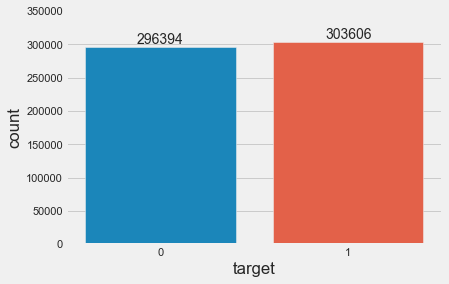

In [64]:
# Target values distribution

ax = sns.countplot(trn['target'])

ax.bar_label(ax.containers[0])
ax.set_ylim(0, 350000)
plt.style.use(['fivethirtyeight'])
plt.show()

In [6]:
features = trn.columns[:-1]
target = trn.columns[-1]

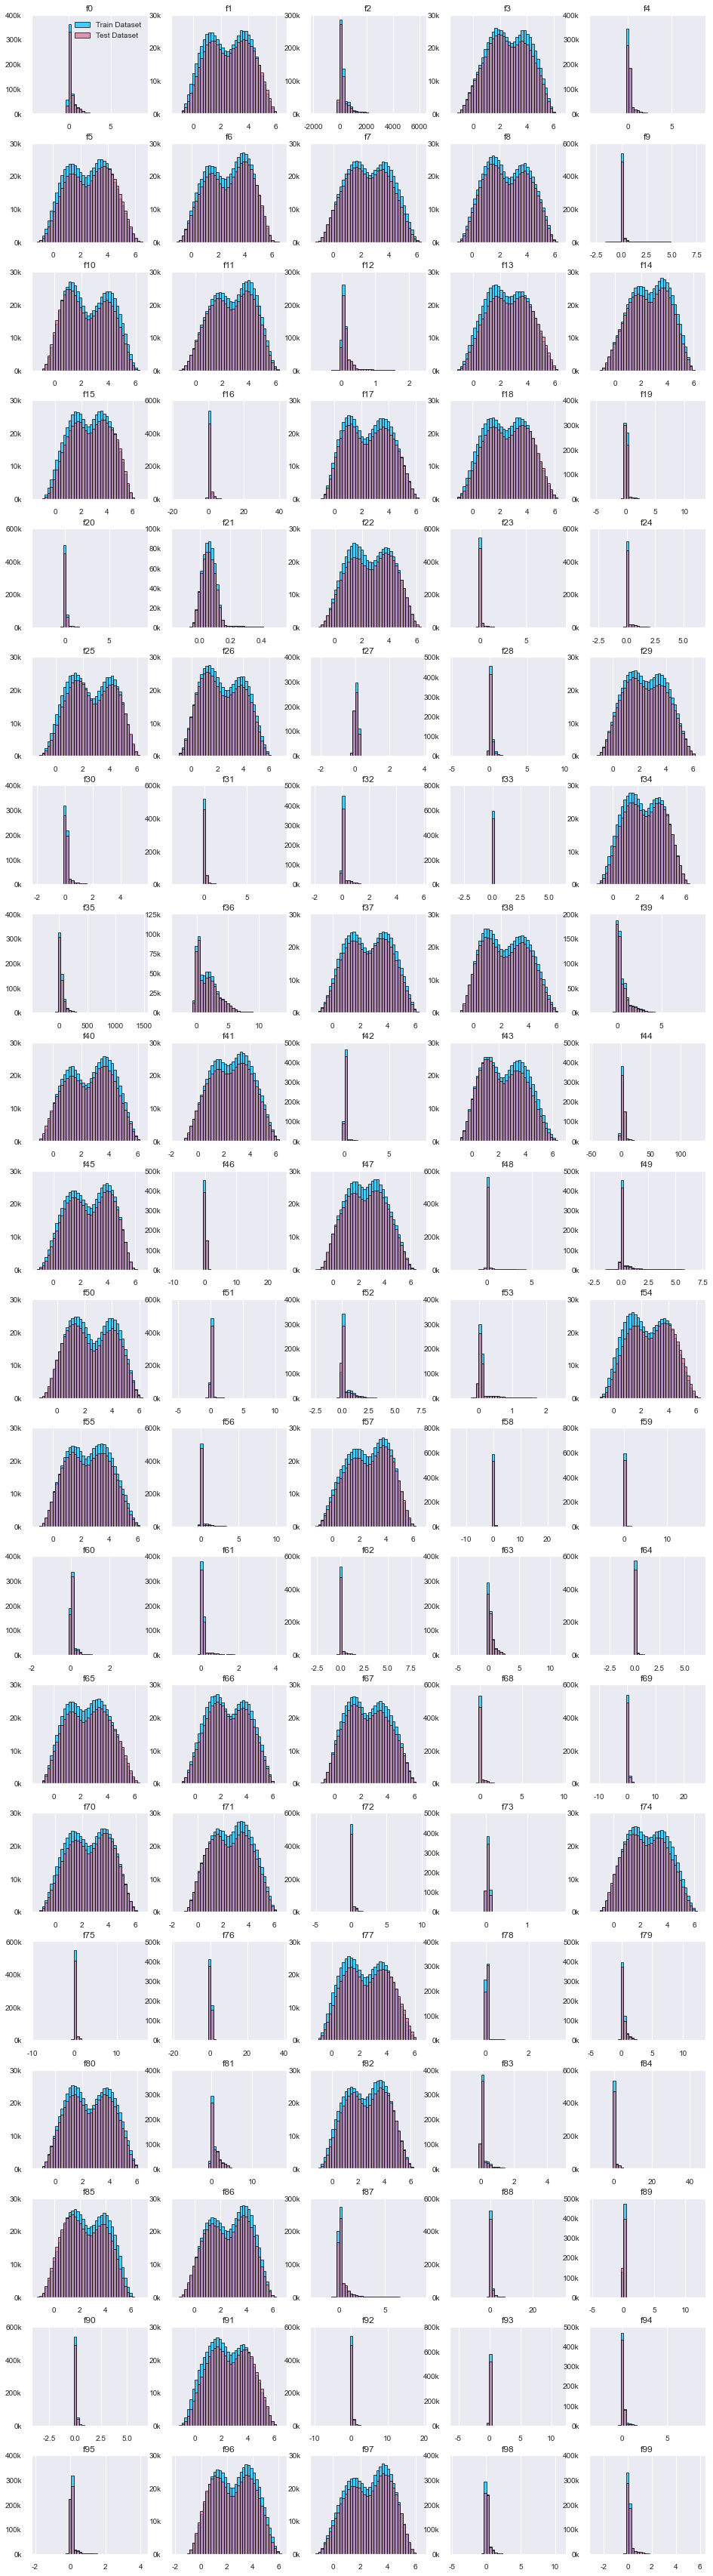

In [62]:
# Thanks to https://www.kaggle.com/maximkazantsev/tps-11-21-eda-xgboost-optuna#Data-preprocessing

df = pd.concat([trn[features], tst[features]], axis=0)

columns = df.columns.values

cols = 5
rows = len(columns) // cols + 1

fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(16,65), sharex=False)

plt.subplots_adjust(hspace = 0.3)
i=0

for r in np.arange(0, rows, 1):
    for c in np.arange(0, cols, 1):
        if i >= len(columns):
            axs[r, c].set_visible(False)
        else:
            hist1 = axs[r, c].hist(trn[columns[i]].values,
                                   range=(df[columns[i]].min(),
                                          df[columns[i]].max()),
                                   bins=40,
                                   color="deepskyblue",
                                   edgecolor="black",
                                   alpha=0.7,
                                   label="Train Dataset")
            hist2 = axs[r, c].hist(tst[columns[i]].values,
                                   range=(df[columns[i]].min(),
                                          df[columns[i]].max()),
                                   bins=40,
                                   color="palevioletred",
                                   edgecolor="black",
                                   alpha=0.7,
                                   label="Test Dataset")
            axs[r, c].set_title(columns[i], fontsize=12, pad=5)
            axs[r, c].set_yticks(axs[r, c].get_yticks())
            axs[r, c].set_yticklabels([str(int(i/1000))+"k" for i in axs[r, c].get_yticks()])
            axs[r, c].tick_params(axis="y", labelsize=10)
            axs[r, c].tick_params(axis="x", labelsize=10)
            axs[r, c].grid(axis="y")
            if i == 0:
                axs[r, c].legend(fontsize=10)
                                  
        i+=1

plt.show();

In [7]:
trn['sum'] = trn[features].sum(axis=1)
tst['sum']=tst[features].sum(axis=1)

trn['mean']=trn[features].mean(axis=1)
tst['mean']=tst[features].mean(axis=1)

trn['median']=trn[features].median(axis=1)
tst['median']=tst[features].median(axis=1)

trn['std'] = trn[features].std(axis=1)
tst['std'] = tst[features].std(axis=1)

trn['max'] = trn[features].max(axis=1)
tst['max'] = tst[features].max(axis=1)

trn['min'] = trn[features].min(axis=1)
tst['min'] = tst[features].min(axis=1)

trn['kurt'] = trn[features].kurtosis(axis=1)
tst['kurt'] = tst[features].kurtosis(axis=1)

agg_features= ['sum','mean', 'median', 'std','max','min','kurt']

In [8]:
features = list(features)
features.extend(agg_features)

In [9]:
# scaling

ss = StandardScaler()

for col in features:
    trn[col] = ss.fit_transform(trn[[col]])
    tst[col] = ss.fit_transform(tst[[col]])
    
display(trn.head(3), tst.head(3))

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,target,sum,mean,median,std,max,min,kurt
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.382553,0.705772,-0.315075,0.347277,-0.229657,-0.875660,0.660314,-0.197064,-0.286162,-0.289270,-0.606336,-1.991523,2.044848,0.217196,-0.885121,-0.062120,-0.122517,-1.145251,-0.312363,-9.993477,-0.182572,3.068937,0.495195,-0.262790,0.010758,0.292759,-0.736966,-0.216604,-0.692776,0.181632,-0.454984,-0.349435,-0.499995,-0.321836,0.916046,-0.341286,-0.353635,0.493951,1.611584,-0.734610,-0.339711,0.565760,1.911079,-0.880455,-0.320598,-0.099709,-0.054528,0.544745,-0.106855,2.338970,-1.024272,0.005135,-0.491076,2.418930,1.296466,-0.663374,-0.397379,-1.770458,-0.065358,-0.095368,-0.472032,-0.454579,-0.253166,-0.624425,-0.164981,0.801835,1.560561,1.086307,-0.178258,-0.091762,-0.713023,0.898114,0.122535,-0.225063,-0.336220,-0.297084,-0.102914,0.697735,-0.358560,-0.748786,1.804863,-0.493052,0.579353,-0.167943,-0.218862,1.036664,0.939336,-0.405475,-0.457500,0.079465,-0.537157,-0.872508,-0.258806,-0.595537,-0.199502,-0.196145,1.067358,-0.400887,-0.167145,0.443374,0,-0.389836,-0.389836,-0.378987,-0.402405,-0.379057,0.180287,0.666864
1,-0.347377,-0.530387,-0.417061,0.472862,-0.187909,1.623543,-0.910506,-1.963980,1.309644,-0.229122,-1.401307,-1.575303,-0.317358,-0.141724,1.131316,-1.865393,-0.095735,0.569401,-0.368669,-0.101748,-0.469516,-1.022379,0.028692,0.019125,-0.214432,1.350376,-0.384964,-2.100945,-0.614259,0.455936,-0.383689,-0.207391,-0.229485,0.568413,-1.371233,-0.239895,-0.054454,-1.922648,1.618129,-0.526466,-0.027368,-0.408527,-0.289578,0.501084,-0.122425,-1.140035,-0.097837,1.385030,5.087575,-0.287317,-1.165299,-0.198774,-0.226644,0.003789,0.189693,-1.168957,-0.095997,1.537982,0.061811,-0.221611,-0.685045,-0.410366,-0.144235,-0.381455,0.033450,-1.021772,-1.244762,1.164920,-0.108216,-0.303169,0.712750,0.305192,-0.418982,0.009943,-0.414007,-0.079093,-0.210974,-0.559819,-0.456462,-0.488488,0.704681,-0.764721,-0.155978,-0.581023,-0.136735,0.965419,0.568495,-0.462362,-0.215757,0.412899,0.573313,0.658473,-0.252018,0.548089,0.019765,2.392938,-1.806811,-0.008064,-0.412110,-0.371198,0,-0.482061,-0.482061,-1.064595,-0.499431,-0.482332,0.283529,-0.130957
2,-0.517136,-0.643571,-0.132486,-0.293650,-0.361533,0.364863,1.507175,0.824771,-0.480372,-0.183401,-1.403217,0.135604,-0.112464,-0.268667,1.786143,-0.833570,-0.463844,-0.699858,-0.642468,-0.221482,-0.332069,0.861216,-0.562888,-0.176507,-0.050642,-0.911803,0.709590,0.548987,-0.397030,-0.156019,-0.415992,-0.151872,-0.354118,-0.393733,-1.893472,-0.168756,-0.197126,-0.975184,0.516535,1.605786,0.278119,-1.265445,-0.325299,-1.835383,2.607623,0.708144,-0.260927,-0.638419,-0.112700,-0.396710,0.081937,-0.218914,-0.595770,0.010588,-0.174592,-1.950380,-0.340193,0.555281,-0.053391,-0.224661,-0.654536,-0.308736,-0.317419,-0.624568,-0.411837,-0.427578,-0.110521,-1.377375,-0.192276,0.451024,-0.207039,-1.170251,-0.129693,0.873608,1.584122,-0.288303,-0.128620,-1.382301,-0.256700,0.055052,0.822826,-0.767039,0.740751,-0.052985,-0.219325,-1.261127,-0.341074,-0.331482,0.648202,-0.234109,0.408845,1.580886,-0.127714,-0.226174,-0.062423,-0.516946,-1.968603,-0.294434,-0.078904,0.094984,0,-0.183119,-0.183119,-1.212312,-0.213565,-0.194161,0.282036,0.613546


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,sum,mean,median,std,max,min,kurt
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
600000,-0.610037,1.438550,0.648515,-0.196663,1.070989,0.764179,-1.437751,-0.655677,1.540162,-0.174163,1.097662,0.295162,-0.646900,-0.515344,0.027044,-1.318935,-0.319169,-0.565670,0.978935,-0.447408,0.055652,-0.127067,-1.404582,0.814142,0.040901,1.476293,-0.114429,-1.069190,-1.273303,-0.584437,-0.198261,-0.280096,-0.368288,0.080119,1.943886,-0.394126,1.118989,-1.682929,-0.003810,0.179705,-1.852809,1.176068,-0.137373,0.272416,0.077108,0.851223,0.225677,-1.185960,-0.302018,-0.405925,-0.898527,0.041692,-0.414022,-0.107264,1.114095,-0.461139,-0.258609,-0.459522,0.036337,0.009670,-0.391961,-0.252248,-0.157084,-0.504894,-0.023384,1.064261,-0.322758,-1.177086,-0.343363,-0.262381,-0.446161,-0.830676,-0.336244,-0.086106,0.485371,-0.180811,-0.074815,0.862018,-0.247908,-0.642029,0.312749,-0.625807,0.345328,-0.473376,-0.264917,0.754475,1.430722,-0.354292,0.465543,0.232856,0.421457,-0.996922,-0.05954,0.217314,-0.210632,-0.428845,-1.372877,-0.482770,-0.062208,-0.438379,0.529623,0.529623,-0.998698,0.562651,0.588316,0.309482,0.872415
600001,-0.600548,-1.368777,-0.732564,0.280415,-0.394302,-0.966111,1.433074,0.025025,1.317968,-0.155336,-1.322397,1.127593,-0.585944,0.488063,0.529292,-1.042556,1.122797,-0.477542,0.105024,-0.399382,-0.254185,-0.437753,-1.182141,-0.251924,-0.256686,-1.478505,1.630729,0.678097,0.450929,-0.791320,-0.327538,-0.342219,-0.359315,-0.392269,1.559368,-0.223348,3.549133,1.438560,-0.359819,-0.667387,-0.382947,-0.412639,-0.203991,0.123087,0.544719,-1.427535,0.200237,-0.789473,0.028602,0.711024,-0.107874,-0.432035,-0.060392,0.017920,1.048233,-1.210275,-0.262035,0.107616,0.009682,-0.220357,-0.143372,-0.208716,-0.247029,0.372344,-0.274157,-1.976515,0.514794,-0.393101,-0.236913,-0.304861,0.021614,0.357759,-0.340705,1.226290,1.445990,-0.153955,-0.149550,0.293370,3.966044,-0.602553,0.154700,1.676212,1.562077,-0.526592,-0.206554,-0.909618,-0.063389,-0.534230,-0.056462,-0.685603,-0.972829,0.014080,-0.05742,-0.174571,-0.003470,-0.454131,-1.808722,0.682680,-0.257436,-0.069584,-0.753133,-0.753133,-0.024269,-0.424746,-0.562601,-2.278177,0.291600
600002,1.964389,-0.117260,-0.758478,0.625959,1.154632,1.038707,-0.702148,1.460162,-0.394016,-0.301865,-0.236037,-1.388780,0.024577,-0.632237,1.150048,-0.691159,-0.356391,-0.560044,1.027997,-0.115941,-0.331572,-0.769401,0.267527,-0.120073,-0.114006,0.523933,-0.851775,-0.315018,-0.581605,0.658168,-0.327213,-0.333172,-0.276586,-0.478737,1.751759,-0.324202,-0.887958,1.176543,0.098333,-0.520275,1.821465,-0.493602,-0.226337,0.440475,0.345129,-1.509252,0.200744,-1.343879,-0.421136,-0.131167,0.771626,-0.198290,-0.233526,-0.320706,0.598820,-1.042021,-0.363658,-0.520697,-0.116026,-0.315140,-0.158724,-0.381144,-0.327702,-0.421434,0.032269,0.475229,0.661969,1.425037,-0.181532,-0.354349,-0.517381,-1.739318,-0.406893,-0.520278,-1.467302,-0.191445,-0.206495,-1.072217,0.031365,0.388334,-0.688530,-0.676002,-0.918351,-0.215086,-0.074205,1.292844,-0.079245,-0.577772,-0.108659,0.884658,-0.876698,-0.372464,-0.28391,0.200842,-0.002171,2.121127,1.028314,0.449147,-0.114870,-0.258574,-0.817247,-0.817247,-0.734838,-0.403473,-0.587548,-2.611903,0.649776


In [10]:
# train_test_split

X_trn = trn[features]
y_trn = trn[target]
X_tst = tst[features]

display(X_trn.shape, y_trn.shape, X_tst.shape)

(600000, 107)

(600000,)

(540000, 107)

In [141]:
# k-fold cross validation, trial with the default parameter.


# RANDOM_SEED = 42
# n_splits = 5
# skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

# tst_preds = []
# mean_auc = 0

# model = LGBMClassifier(random_state = RANDOM_SEED)

# for fold, (trn_idx, val_idx) in tqdm(enumerate(skf.split(X_trn, y_trn))):
#     X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
#     y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]
    
#     model.fit(X_train, y_train,
#              verbose = False,
#              eval_set = [(X_train, y_train), (X_val, y_val)],
#              eval_metric = 'auc',
#              early_stopping_rounds = 100)
    
#     y_pred = model.predict_proba(X_val)
#     score = roc_auc_score(y_val, y_pred[:,1])
#     mean_auc += score
    
#     print(f"Fold {fold}'s score: {score}")
        
#     tst_preds.append(model.predict_proba(X_tst)[:, 1])

# print("==========================================")
# print(f"Mean auc of all folds: {mean_auc / n_splits}")

In [92]:
# # HPO using opuna

# def lgb_objective(trial):
#     params = {
#         'boosting_type': 'gbdt',
#         'objective': 'binary',
#         'n_estimators': trial.suggest_int("n_estimators", 64, 8192),
#         'learning_rate': trial.suggest_float("learning_rate", 1e-3, 0.25, log=True),
#         'num_leaves': trial.suggest_int("num_leaves", 20, 3000),
#         'max_depth': trial.suggest_int("max_depth", 3, 12),
#         'feature_fraction': trial.suggest_float("feature_fraction", 0.1, 1.0),
#         'min_gain_to_split' : trial.suggest_int('min_gain_to_split', 0, 15),
#         'min_data_in_leaf' : trial.suggest_int("min_data_in_leaf", 100, 1000),
#         'lambda_l1': trial.suggest_loguniform("lambda_l1", 1e-8, 100.0),
#         'lambda_l2': trial.suggest_loguniform("lambda_l2", 1e-8, 100.0),
#         'bagging_fraction' : trial.suggest_float("bagging_fraction", 0, 0.8),
#         'bagging_freq' : trial.suggest_int("bagging_freq", 1, 100),
#         'seed': 42,
#         'deterministic': True,
#         'metric' : 'auc',
#         'verbose':-1
#     }
    
#     X_train, X_val, y_train, y_val = train_test_split(X_trn, y_trn, test_size = 0.3, random_state = 42)
    
#     model = LGBMClassifier(**params)
#     model.fit(X_train, y_train,
#              eval_set = [(X_train, y_train), (X_val, y_val)],
#              early_stopping_rounds = 100,
#              eval_metric = 'auc',
#              verbose = False
#              )
#     pred_val = model.predict(X_val)
    
#     return roc_auc_score(y_val, pred_val)

In [140]:
# sampler = TPESampler(seed = 42)
# study = optuna.create_study(study_name = 'lgbm_hpo',
#                            direction = 'maximize',
#                            sampler = sampler)
# study.optimize(lgb_objective, n_trials = 10)

# print("Best AUC:", study.best_value)
# print("Best params:", study.best_params)

In [95]:
# params = study.best_params

In [11]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'n_estimators': 7276, 
          'learning_rate': 0.013562603384785458,
          'num_leaves': 376,
          'max_depth': 10,
          'feature_fraction': 0.7847065437552077,
          'min_gain_to_split': 8,
          'min_data_in_leaf': 794,
          'lambda_l1': 0.0008668739724852811,
          'lambda_l2': 0.0016878284140548435,
          'bagging_fraction': 0.3420328146868397,
          'bagging_freq': 3,
          'seed': 42,
          'deterministic': True,
          'metric' : 'auc',
          'verbose':-1
         }

In [12]:
RANDOM_SEED = 42
n_splits = 5
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

tst_preds = []
mean_auc = 0

model = LGBMClassifier(**params)

for fold, (trn_idx, val_idx) in tqdm(enumerate(skf.split(X_trn, y_trn))):
    X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
    y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]
    
    model.fit(X_train, y_train,
             verbose = False,
             eval_set = [(X_train, y_train), (X_val, y_val)],
             eval_metric = 'auc',
             early_stopping_rounds = 100)
    
    y_pred = model.predict_proba(X_val)
    score = roc_auc_score(y_val, y_pred[:,1])
    mean_auc += score
    
    print(f"Fold {fold}'s score: {score}")
        
    tst_preds.append(model.predict_proba(X_tst)[:, 1])

print("==========================================")
print(f"Mean auc of all folds: {mean_auc / n_splits}")

0it [00:00, ?it/s]

Fold 0's score: 0.7447556554235197


1it [02:18, 138.78s/it]

Fold 1's score: 0.7450950613782783


2it [04:48, 144.96s/it]

Fold 2's score: 0.7469013680427958


3it [07:24, 150.13s/it]

Fold 3's score: 0.7468890637660548


4it [09:55, 150.67s/it]

Fold 4's score: 0.7489920226548716


5it [12:11, 146.28s/it]

Mean auc of all folds: 0.7465266342531041


In [13]:
final_preds = np.mean(tst_preds, axis = 0)
submission = pd.read_csv('./input/tabular-playground-series-nov-2021/sample_submission.csv')
submission['target'] = final_preds
submission

,id,target
0,600000,0.668786
1,600001,0.595119
2,600002,0.838400
3,600003,0.522118
4,600004,0.522843
...,...,...
539995,1139995,0.657281
539996,1139996,0.673702
539997,1139997,0.528474
539998,1139998,0.643027


In [14]:
submission.to_csv('submission_02.csv', index = False)